# Libraries

In [1]:
import pandas as pd

import numpy as np

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

from matplotlib import pyplot
import seaborn as sb
import pickle
import time
import warnings
from spade.agent import Agent
from spade.behaviour import CyclicBehaviour
import os
import random

In [2]:
warnings.filterwarnings("ignore")

# Coordinate Agent

- The Coordinate Agent incorporates three processes including Preprocess, Split, and Train
- The Preprocess module takes data. It changes string features into integer by using convert function, normalize the converted data by using normalize function, shortlist the features by applying feature_selection function, and balance the data by applying data_balance function
- After preprocessing it saves the data into Memory directory
- The Split moduls takes the data and split it into training features, testing features, training labels, and testing labels
- After splitting it saves all four into Memory directory
- The Training module takes training feaures, testing features, training labels, and testing labels and train Support Vector Machine classifier and Multi-Layer Perceptron classifier.
- After training it saves the models into Models directory and training time into Memory directory

In [3]:
class CoordinateAgent(Agent):
    
    class Preprocess(CyclicBehaviour):
        
        async def on_start(self):
            print('Preprocessing ....')

        
        async def run(self):
            
            kdd_train = pickle.load(open('Memory/kdd_train.sav', 'rb'))
            
            kdd_train = convert(kdd_train)
    
            kdd_train = normalize(kdd_train)
    
            kdd_train = feature_selection(kdd_train)
        
            kdd_train = data_balance(kdd_train)
            
            
            pickle.dump(kdd_train, open('Memory/kdd_train.sav', 'wb'))
            
            self.kill(exit_code=0)
    
    
    
    class Split(CyclicBehaviour):
        
        async def on_start(self):
            print('Spliting ...')
            split_data = pickle.load(open('Memory/kdd_train.sav', 'rb'))
        
        async def run(self):
            x_train, x_test, y_train, y_test = train_test_split(split_data.iloc[:,:-1], 
                                                                split_data.iloc[:,-1], 
                                                                test_size=0.33)
            
            pickle.dump(x_train, open('Memory/x_train.sav', 'wb'))
            pickle.dump(x_test, open('Memory/x_test.sav', 'wb'))
            
            pickle.dump(y_train, open('Memory/y_train.sav', 'wb'))
            pickle.dump(y_test, open('Memory/y_test.sav', 'wb'))
            
            self.kill(exit_code=0)
    
    
    
    class Training(CyclicBehaviour):
        
        async def on_start(self):
            print('Training ...')
        
        async def run(self):
            
            x_train = pickle.load(open('Memory/x_train.sav', 'rb'))
            x_test = pickle.load(open('Memory/x_test.sav', 'rb'))
            y_train = pickle.load(open('Memory/y_train.sav', 'rb'))
            y_test = pickle.load(open('Memory/y_test.sav', 'rb'))
            
            
            models = {

                'Support Vector Machine' : SVC(),

                'Multi-Layer Perceptron' : MLPClassifier()
            }

            for key in models.keys(): 

                model = models[key]

                model, time_diff = train(x_train, y_train, model)

                print('{} Training Time : {} s'.format(key, time_diff))


                if key == 'Support Vector Machine':
                    pickle.dump(model, open('Models/svc.sav', 'wb'))
                    pickle.dump(time_diff, open('Memory/svc_time.sav', 'wb'))

                if key == 'Multi-Layer Perceptron':
                    pickle.dump(model, open('Models/mlp.sav', 'wb'))
                    pickle.dump(time_diff, open('Memory/mlp_time.sav', 'wb'))
            
            self.kill(exit_code=0)
            
    
    async def setup(self):
        
        if preprocess_status:    
            self.prep = self.Preprocess()
            self.add_behaviour(self.prep)
        
        
        if split_status:
            
            split_obj = self.Split()
            self.add_behaviour(split_obj)
        
        
        if training_status:
            
            train_obj = self.Training()
            self.add_behaviour(train_obj)

# Testing Agent

- The Testing Agent contains only one module name Test
- On calling Testing Agent it takes testing features and testing labels from Memory directory. It also loads both trained models including Support Vector Machine and Multi-Layer Perceptron from the Models directory
- After testing it saves the prediction, accuracy, f1 score, and false positive rate into Memory directory for both models

In [4]:
class Testing(Agent):
    
    class Test(CyclicBehaviour):
        
        async def on_start(self):
            print('Testing ...')
            
        
        async def run(self):
            
            x_test = pickle.load(open('Memory/x_test.sav', 'rb'))
            
            y_test = pickle.load(open('Memory/y_test.sav', 'rb'))
            
            svc = pickle.load(open('Models/svc.sav', 'rb'))
            
            mlp = pickle.load(open('Models/mlp.sav', 'rb'))
            
            svc_pred, svc_score, svc_f1, svc_fpr = test(x_test, y_test, svc)
            
            mlp_pred, mlp_score, mlp_f1, mlp_fpr = test(x_test, y_test, mlp)
            
            pickle.dump(svc_pred, open('Memory/svc_pred.sav', 'wb'))
            pickle.dump(svc_score, open('Memory/svc_score.sav', 'wb'))
            pickle.dump(svc_f1, open('Memory/svc_f1.sav', 'wb'))
            pickle.dump(svc_fpr, open('Memory/svc_fpr.sav', 'wb'))
            
            pickle.dump(mlp_pred, open('Memory/mlp_pred.sav', 'wb'))
            pickle.dump(mlp_score, open('Memory/mlp_score.sav', 'wb'))
            pickle.dump(mlp_f1, open('Memory/mlp_f1.sav', 'wb'))
            pickle.dump(mlp_fpr, open('Memory/mlp_fpr.sav', 'wb'))
            
            self.kill(exit_code=0)
    
    
    async def setup(self):
        
        self.test_obj = self.Test()
        self.add_behaviour(self.test_obj)

# Analysis Agent

- The Analysis Agent contains only one module named as Analyze
- It loads trained class label encoded to convert integer into string for the attacks
- It loads testing labels for getting plotted
- It loads prediction, accuracy, f1 score, and false positive rate for both models from the Memory directory
- It puts all these values into the Plots function which generates histogram plots for actual and predicted values for each model
- These plots also contains accuracy, f1 score, and false positive rate

In [5]:
class AnalysisAgent(Agent):
    
    class Analyze(CyclicBehaviour):
        
        async def on_start(self):
            
            print('Analyzing ...')

        
        async def run(self):
    
            class_le = pickle.load(open('Models/class_le.sav', 'rb'))
            
            y_test = pickle.load(open('Memory/y_test.sav', 'rb'))
            
            svc_pred = pickle.load(open('Memory/svc_pred.sav', 'rb'))
            svc_score = pickle.load(open('Memory/svc_score.sav', 'rb'))
            svc_f1 = pickle.load(open('Memory/svc_f1.sav', 'rb'))
            svc_fpr = pickle.load(open('Memory/svc_fpr.sav', 'rb'))
            
            mlp_pred = pickle.load(open('Memory/mlp_pred.sav', 'rb'))
            mlp_score = pickle.load(open('Memory/mlp_score.sav', 'rb'))
            mlp_f1 = pickle.load(open('Memory/mlp_f1.sav', 'rb'))
            mlp_fpr = pickle.load(open('Memory/mlp_fpr.sav', 'rb'))
        
            plots(class_le.inverse_transform(y_test), class_le.inverse_transform(svc_pred), svc_score, svc_f1, svc_fpr, 'Support Vector Machine')
    
            plots(class_le.inverse_transform(y_test), class_le.inverse_transform(mlp_pred), mlp_score, mlp_f1, mlp_fpr, 'Multi-Layer Perceptron')
            
            self.kill(exit_code=0)
    
    async def setup(self):
        
        self.analyze = self.Analyze()
        self.add_behaviour(self.analyze)

# Data Loading Function

- This functions takes fours dataset including kdd_train, kdd_test, nsl_train_csv, and nsl_train_txt
- It loads all the files, convert them into DataFrame, and properly check the names of the features

In [6]:
def data_load(kdd_train_path, kdd_test_path, nsl_train_csv_path, nsl_train_txt_path):
    
    columns = pd.read_csv(nsl_train_csv_path).columns
    
    kdd_train = pd.read_csv(kdd_train_path, header=None)
    kdd_train.columns = columns
    kdd_train.rename(columns={'class' : 'attack'}, inplace=True)
    
    kdd_test = pd.read_csv(kdd_test_path, header=None)
    kdd_test.columns = columns[:-1]
    
    f_train = open(nsl_train_txt_path,'r')
    train_lines = f_train.readlines()

    train_rows = []
    for train_line in train_lines:
        elements = train_line.split(',')[:-1]
        elements[-1] = elements[-1]+'.'
        train_rows.append(elements)

    nsl_train = pd.DataFrame(data=train_rows, columns=columns)
    nsl_train.rename(columns={'class' : 'attack'}, inplace=True)
    
    return kdd_train, kdd_test, nsl_train

# Mark Zero Day Attack Function

- It takes data as input
- It keeps unchange the mentioned attack and replace other attacks by zero-day

In [7]:
def mark_zeroday(data):
    
    attacks = [ 'ftp_write.', 'guess_passwd.', 'imap.', 'phf.', 'multihop.',  # R2L
                'buffer_overflow.', 'loadmodule.', 'rootkit.', 'perl.',       # U2R
                'back.', 'pod.', 'smurf.', 'neptune.', 'land.',               # DOS
                'satan.', 'ipsweep.', 'nmap.', 'portsweep.',                  # Probe
                'normal.']                                                    # Normal

    data.loc[~data['attack'].isin(attacks), 'attack'] = 'zero-day'
    
    return data

# String and Float Converting Function

- It takes the data
- It converts the string carrying features into string data type
- It converts the float carrying features into float data type
- This process is done because sometimes data gets loaded as object not as string or float

In [8]:
def str_float_features(data):
    
    str_columns = ['protocol_type','service','flag','attack']
    
    for col in data.columns:
        if col not in str_columns:
            data[col] = data[col].astype(float)
        if col in str_columns:
            data[col] = data[col].astype('string')

    
    return data

# Converting Labels From String to Integer Function

- It takes the data
- It loads pretrained encoders for all string features
- It convert all the string into integer for each string features in the dataset

In [9]:
def convert(data):
    
    protocol_le = pickle.load(open('Models/protocol_le.sav', 'rb'))
    service_le = pickle.load(open('Models/service_le.sav', 'rb'))
    flag_le = pickle.load(open('Models/flag_le.sav', 'rb'))
    class_le = pickle.load(open('Models/class_le.sav', 'rb'))


    data['protocol_type'] = protocol_le.transform(data['protocol_type'])

    data['service'] = service_le.transform(data['service'])

    data['flag'] = flag_le.transform(data['flag'])

    data['attack'] = class_le.transform(data['attack'])
    
    return data

# Normalizing Function

- It takes data
- It select only those features which contain floating points
- It normalizes all these features

In [10]:
def normalize(data):
    
    str_columns = ['protocol_type', 'service', 'flag', 'attack']
    
    scaler = pickle.load(open('Models/scaler.sav', 'rb'))
    
    float_features = data.loc[:, ~data.columns.isin(str_columns)]
    
    data[float_features.columns] = pd.DataFrame(data=scaler.transform(float_features), columns=float_features.columns)
    
    return data

# Feature Selection Function

- It takes data
- It contains 15 mandatory columns names
- It shorlist the data without mandatory columns
- It applies pretrained autoencoder to shortlist the 10 features from 27 features
- It concatenate the mandatory columns and shortlisted columns which in total becomes 25 features

In [11]:
def feature_selection(data):
    
    mad_columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
                   'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 
                   'logged_in', 'num_compromised', 'root_shell','su_attempted', 
                   'num_root']

    mad_features = data.loc[:, data.columns.isin(mad_columns)]
    opt_features = data.loc[:, ~data.columns.isin(mad_columns+['attack'])]
    
    encoder = load_model('Models/encoder.h5')
    
    short_features = pd.DataFrame(data=encoder.predict(opt_features))
    short_features = pd.DataFrame(MinMaxScaler().fit_transform(short_features),  
                                  columns= opt_features.columns[np.arange(1, len(opt_features.columns), 2)[:10]]) #np.arange(list(opt_features.columns), k=10))

    new_data = pd.concat([mad_features, short_features], axis=1)
    new_data['attack'] = data['attack']

    return new_data

# Data Balancing Function

- It takes the data
- It shortliste data for each unique attack
- It saves the 5000 samples for each unique attack
- If the samples are lower than 5000 then all are included
- It concatenates all

In [12]:
def data_balance(new_data):
    
    chunks = []
    for attack in new_data['attack'].unique():
        chunk = new_data[new_data['attack'] == attack]

        if len(chunk) < 5000:
            chunks.append(chunk)
        else:
            chunks.append(chunk.iloc[:5000, :])

    balanced_data = pd.concat(chunks, axis=0).fillna(0)
    
    return balanced_data

# Data Splitting Function

- It takes data and optional test sizing variable
- It splits the dataset according to the test size given. By default it splits data as 67% training and 33% testing

In [13]:
def data_split(x, y, test_size=0.33):
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
    
    return x_train, x_test, y_train, y_test

# False Rate Function

- It takes actual and predicted values
- It computes confusion matrix
- It computes false positive and true negative
- It computes fals positive rate by interatively adding fraction of false positive into sum of false positive and true negative

In [14]:
def false_rate(actual, predicted):
    
    cm = confusion_matrix(predicted, actual)
    
    fp, tn, fpr = 0, 0, 0
    for i in range(len(cm)):

        fp = cm[:,i].sum() - cm[i,i]

        tn = cm.sum() - (cm[:,i].sum() - cm[i,i]) - (cm[i,:].sum() - cm[i,i])

        fpr += fp/(fp+tn)

    fpr = fpr/(i+1)
    
    return fpr

# Training Function

- It takes training features, training labels, and model
- It fits the data on the model and return the trained model along with training time

In [15]:
def train(x_train, y_train, model):
    
    start_time = time.time()
    
    model.fit(x_train, y_train)
    
    end_time = time.time()
        
    time_diff = end_time - start_time
    
    return model, time_diff

# Testing Function

- It takes testing features, testing labels, and model
- It makes prediction for all testing features
- It computes accuracy by comparing testing labels and prediction
- It computes false positive rate by false rate funtion 

In [16]:
def test(x_test, y_test, model):
    
    pred = model.predict(x_test)
    score = round(model.score(x_test, y_test)*100, 2)
    f1 = round(f1_score(y_test, pred, average='macro'), 2)
    fpr = false_rate(y_test, pred)
    
    return pred, score, f1, fpr

# Correlation Plot Function

- It takes data
- It computes correlation matrix
- It plots correlation matrix as heatmap plot
- It saves the plot in Plots directory

In [17]:
def corr_plot(data):
    pyplot.figure(figsize=[20,20])
    sb.heatmap(data.corr(), annot=True)
    pyplot.savefig('Plots/Correlation.png')
    pyplot.show()

# Plots Function

- It takes testing labels, prediction, accuracy, f1 score, false positive rate, and title
- It draws histogram for actual values and predicted values
- It also mention accuracy, f1 score, and false positive rate on the prediction plot
- It saves the plots into Plots directory

In [18]:
def plots(y_test, predicted, score, f1, fpr, title):
    
    pyplot.figure(figsize=[18,6])
    
    pyplot.title('{} Actual'.format(title))
    pyplot.hist(y_test, bins=len(np.unique(y_test)), edgecolor='black', alpha=0.5, linewidth=1.2)
    pyplot.xlabel('Attack')
    pyplot.ylabel('Count')
    pyplot.xticks(rotation=45)
    pyplot.savefig('Plots/{}_Actual.png'.format(title))
    pyplot.show()

    
    pyplot.figure(figsize=[18,6])
    
    pyplot.title('{} Prediction'.format(title))
    pyplot.hist(predicted, bins=len(np.unique(predicted)), edgecolor='black', color='green', alpha=0.5, 
                linewidth=1.2, label='Accuracy : {}%\nF1_score : {}\nFalse Rate : {}'.format(score, f1, fpr))
    pyplot.xlabel('Attack')
    pyplot.ylabel('Count')
    pyplot.xticks(rotation=45)

    pyplot.legend()

    pyplot.savefig('Plots/{}_Prediction.png'.format(title))
    pyplot.show()

# ROC Function

- It takes data
- It convers multi-labels into binary labels by using label_binaries model
- It train and predict OneVsRestClassifier by embedding Multi-Layer perceptron model in it
- These predicted probabilites score is used along with actual labels for computing ROC curve
- ROC curve shows the relation of True Positive Rate with False Positive Rate
- This ROC is draws for each unique attack
- All the plots get saved inot Plots directory

In [19]:
def ROC(data):
    
    
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values

    
    classes = np.unique(y)
    y = label_binarize(y, classes=classes)
    n_classes = y.shape[1]

    
    random_state = np.random.RandomState(0)
    n_samples, n_features = X.shape
    X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

    
    classifier = OneVsRestClassifier(MLPClassifier())
    classifier.fit(X_train, y_train)
    y_score = classifier.predict_proba(X_test)

    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        
        class_le = pickle.load(open('Models/class_le.sav', 'rb'))
        
        attack = class_le.inverse_transform([classes[i]])[0]
        
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        lw = 2
        pyplot.figure(figsize=[8, 6])
        pyplot.plot(
            fpr[i],
            tpr[i],
            color="darkorange",
            lw=lw,
            label="%s VS Rest (AUC = %0.2f)" % (attack, roc_auc[i]),
        )
        pyplot.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        pyplot.xlim([0.0, 1.0])
        pyplot.ylim([0.0, 1.05])
        pyplot.xlabel("False Positive Rate")
        pyplot.ylabel("True Positive Rate")
        pyplot.title("ROC For {} Attack".format(attack))
        pyplot.legend(loc="lower right")
        pyplot.savefig('Plots/ROC {}.png'.format(attack))
        pyplot.show()

# Main

- This is main cell
- This loads the datasets by calling data_load function
- This marks zero-day attack where needed by calling mark_zeroday function
- This converts datatypes into string and float by calling str_float_features function
- This calls Preprocess module of Coordinate Agent for preprocessing
- This calls Split module of Coordinate Agent for data splitting
- This calls Train module of Coordinate Agent for training purpose
- This calls Test module of Testing Agent for testing purpose
- This calsl Analysis moduel of Analysing Agent for visulaization purpose

Preprocessing ....


something is odd: failure future is already done ...
Exception running behaviour CyclicBehaviour/Split: name 'split_data' is not defined


Spliting ...


Traceback (most recent call last):
  File "C:\Users\Prime Com\AppData\Roaming\Python\Python38\site-packages\spade\behaviour.py", line 295, in _step
    await self._run()
  File "C:\Users\Prime Com\AppData\Roaming\Python\Python38\site-packages\spade\behaviour.py", line 284, in _run
    await self.run()
  File "C:\Users\PRIMEC~1\AppData\Local\Temp/ipykernel_11368/17762341.py", line 35, in run
    x_train, x_test, y_train, y_test = train_test_split(split_data.iloc[:,:-1],
NameError: name 'split_data' is not defined

Exception running behaviour CyclicBehaviour/Training: [Errno 2] No such file or directory: 'Memory/x_train.sav'
Traceback (most recent call last):
  File "C:\Users\Prime Com\AppData\Roaming\Python\Python38\site-packages\spade\behaviour.py", line 295, in _step
    await self._run()
  File "C:\Users\Prime Com\AppData\Roaming\Python\Python38\site-packages\spade\behaviour.py", line 284, in _run
    await self.run()
  File "C:\Users\PRIMEC~1\AppData\Local\Temp/ipykernel_11368/17762

Training ...


Exception running behaviour CyclicBehaviour/Test: [Errno 2] No such file or directory: 'Memory/x_test.sav'
Traceback (most recent call last):
  File "C:\Users\Prime Com\AppData\Roaming\Python\Python38\site-packages\spade\behaviour.py", line 295, in _step
    await self._run()
  File "C:\Users\Prime Com\AppData\Roaming\Python\Python38\site-packages\spade\behaviour.py", line 284, in _run
    await self.run()
  File "C:\Users\PRIMEC~1\AppData\Local\Temp/ipykernel_11368/3002177796.py", line 11, in run
    x_test = pickle.load(open('Memory/x_test.sav', 'rb'))
FileNotFoundError: [Errno 2] No such file or directory: 'Memory/x_test.sav'



Testing ...


Exception running behaviour CyclicBehaviour/Analyze: [Errno 2] No such file or directory: 'Memory/y_test.sav'
Traceback (most recent call last):
  File "C:\Users\Prime Com\AppData\Roaming\Python\Python38\site-packages\spade\behaviour.py", line 295, in _step
    await self._run()
  File "C:\Users\Prime Com\AppData\Roaming\Python\Python38\site-packages\spade\behaviour.py", line 284, in _run
    await self.run()
  File "C:\Users\PRIMEC~1\AppData\Local\Temp/ipykernel_11368/182800727.py", line 14, in run
    y_test = pickle.load(open('Memory/y_test.sav', 'rb'))
FileNotFoundError: [Errno 2] No such file or directory: 'Memory/y_test.sav'



Analyzing ...


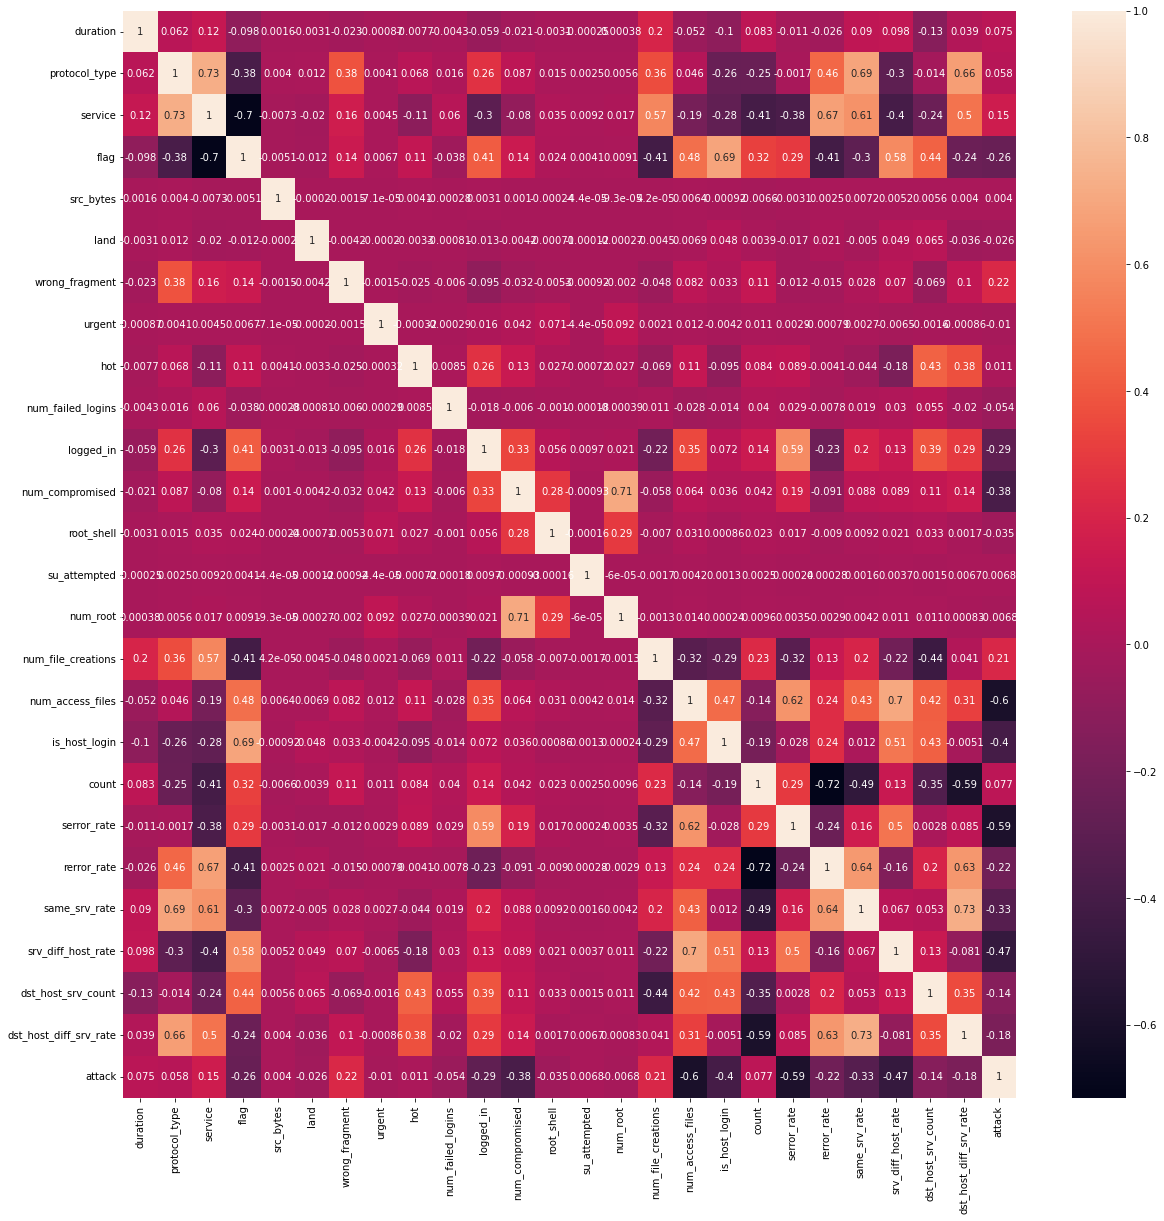

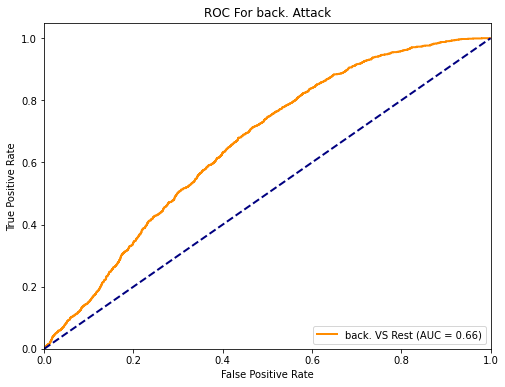

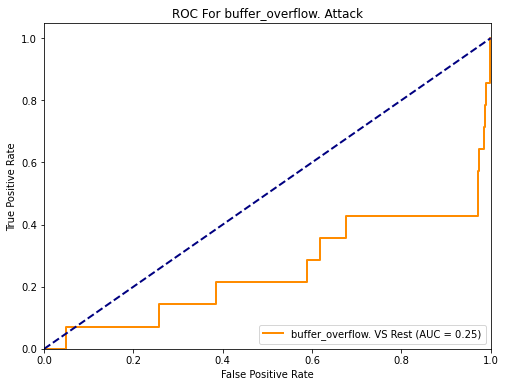

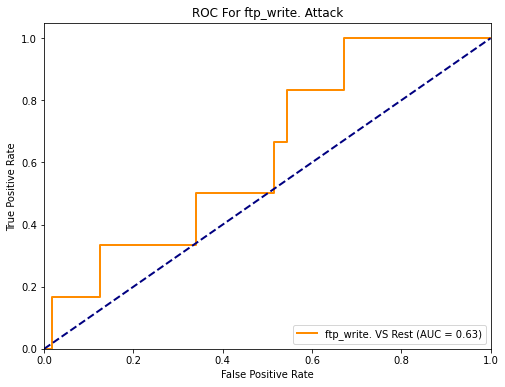

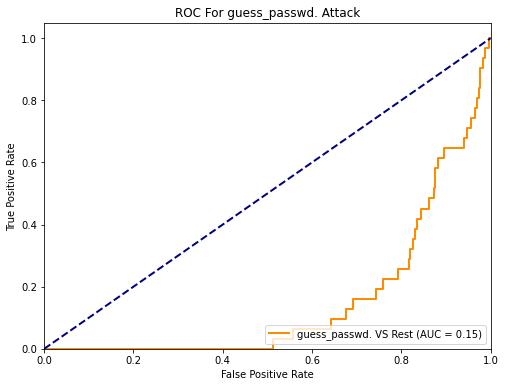

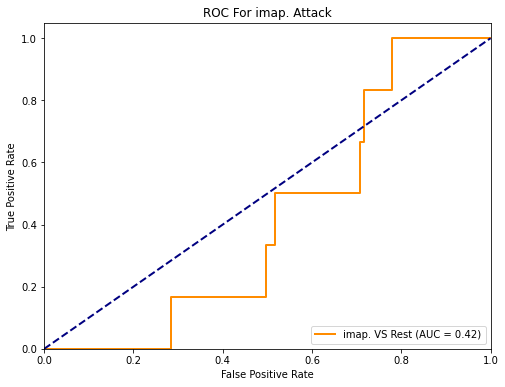

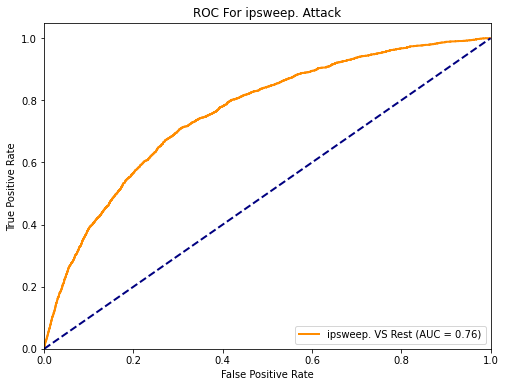

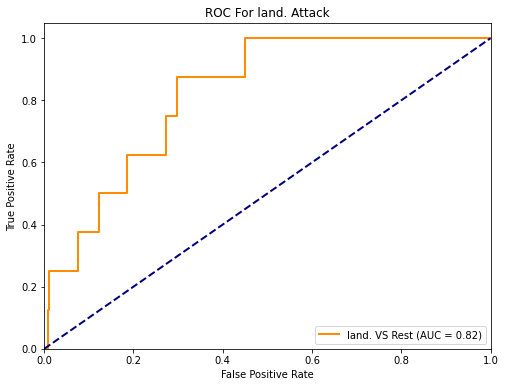

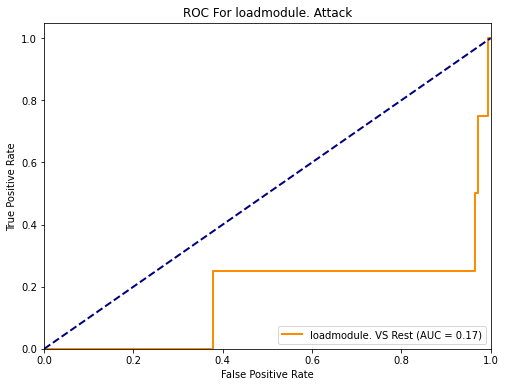

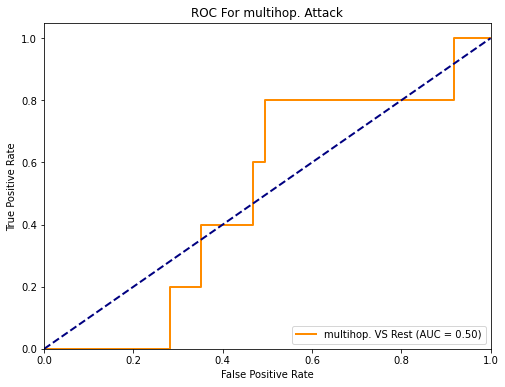

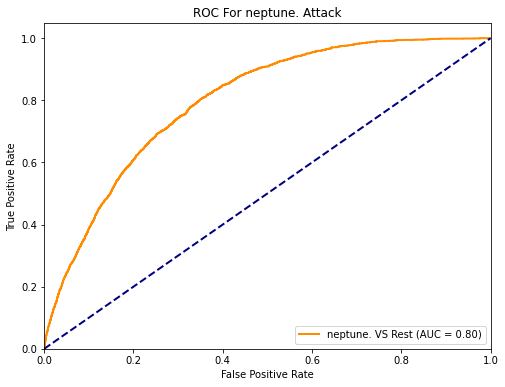

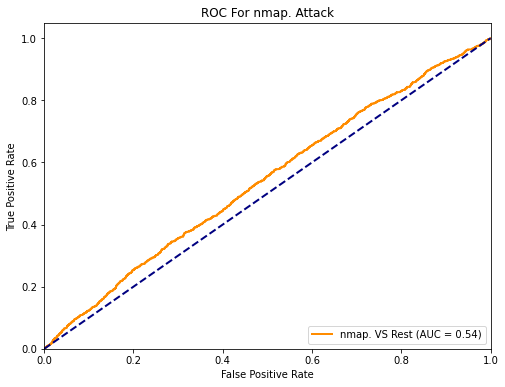

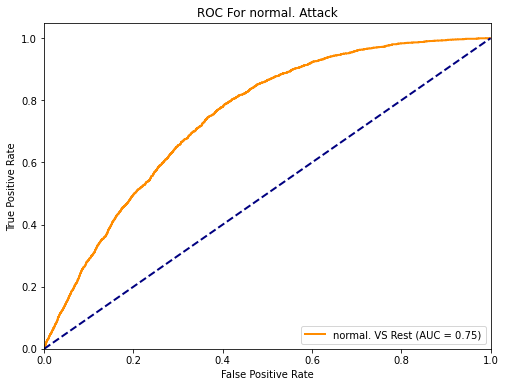

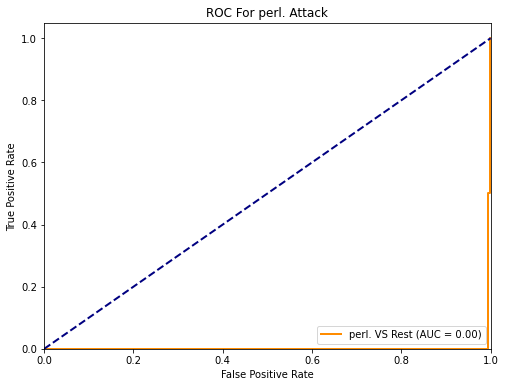

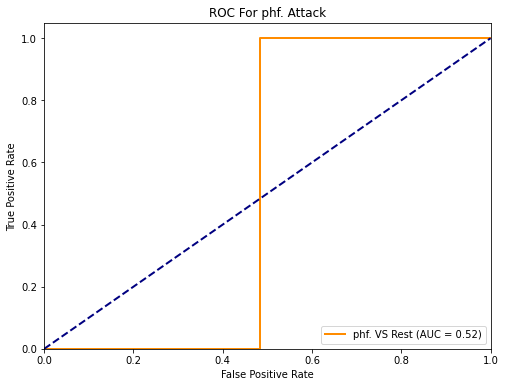

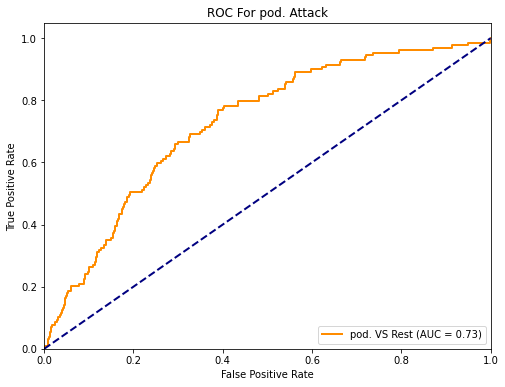

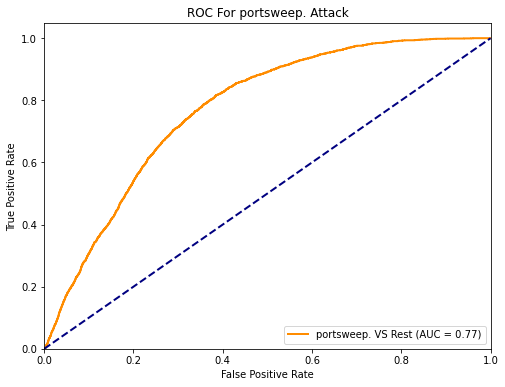

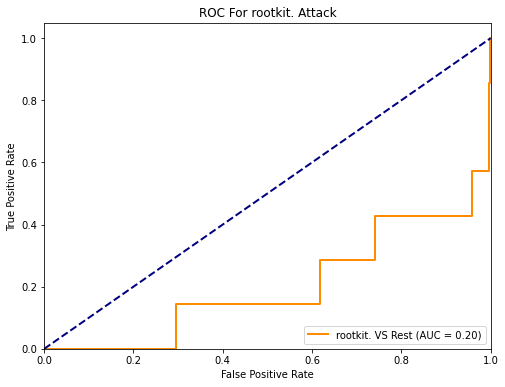

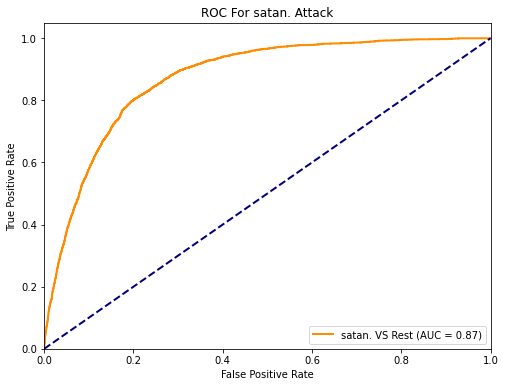

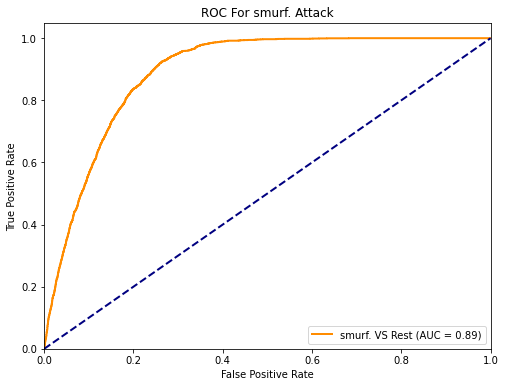

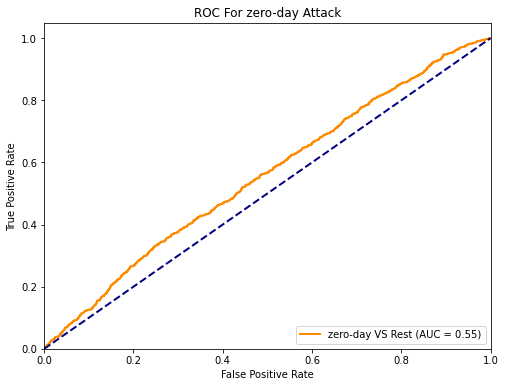

In [20]:
if __name__=='__main__':
    

    kdd_train_path = 'Data/KDD CUP99/kddcup.data/kddcup.data'
    kdd_test_path = 'Data/KDD CUP99/kddcup.testdata.unlabeled/kddcup.testdata.unlabeled'
    nsl_train_csv_path = 'Data/NSL KDD/KDDTrain+.csv'
    nsl_train_txt_path = 'Data/NSL KDD/KDDTrain+.txt'
    
    kdd_train, kdd_test, nsl_train = data_load(kdd_train_path, kdd_test_path,
                                               nsl_train_csv_path, nsl_train_txt_path)
    
    kdd_train = mark_zeroday(kdd_train)
    nsl_train = mark_zeroday(nsl_train)
    
    
    kdd_train = str_float_features(kdd_train)
    kdd_test = str_float_features(kdd_test)
    
    
    os.makedirs('Memory', exist_ok=True)
    
    
    pickle.dump(kdd_train, open('Memory/kdd_train.sav', 'wb'))
    
    

    preprocess_status = True 
    split_status = False
    training_status = False
    
    coord = CoordinateAgent("tufail_ahmad_siddiq@0nl1ne.at", "t00000")
    f = coord.start()
    f.result()
    time.sleep(10)
    coord.stop()

    

    preprocess_status = False 
    split_status = True
    training_status = False
    
    coord = CoordinateAgent("tufail_ahmad_siddiq@0nl1ne.at", "t00000")
    f = coord.start()
    f.result()
    time.sleep(10)
    coord.stop()

    
            
    preprocess_status = False
    split_status = False
    training_status = True
    
    coord = CoordinateAgent("tufail_ahmad_siddiq@0nl1ne.at", "t00000")
    f = coord.start()
    f.result()
    time.sleep(10)
    coord.stop()

    

    testing = Testing("tufail_ahmad_siddiq@0nl1ne.at", "t00000")
    f = testing.start()
    f.result()
    time.sleep(10)
    testing.stop()

    
    analyze = AnalysisAgent("tufail_ahmad_siddiq@0nl1ne.at", "t00000")
    f = analyze.start()
    f.result()
    time.sleep(10)
    analyze.stop()
    
    
    kdd_train = pickle.load(open('Memory/kdd_train.sav', 'rb'))
    
    
    corr_plot(kdd_train)
    
    
    ROC(kdd_train)

<br>